In [20]:
import cvxpy as cp
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
import gzip
f = gzip.open('train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 100

f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)
image = np.asarray(data[0]).squeeze()

In [23]:
# 3 and 8 are both 1s
p1 = np.asarray(data[0]).squeeze()
p0 = np.asarray(data[4]).squeeze()
assert np.sum(p1) >= np.sum(p0)
norm_factor = max(np.sum(p1), np.sum(p0))
p1 = p1 / norm_factor
p0 = p0 / norm_factor
print(np.sum(p1), np.sum(p0))

1.0 0.8433788


In [24]:
n = 28
dx = 1/(n-1)
gamma = 0.7

mx = cp.Variable((n-1,n))
my = cp.Variable((n,n-1))
p0t = cp.Variable((n,n))
p1t = cp.Variable((n,n))
col0 = np.zeros((n,1))
row0 = np.zeros((1,n))

objective = cp.Minimize(cp.sum(cp.norm(cp.vstack([cp.vec(cp.hstack([my, col0])), cp.vec(cp.vstack([mx, row0]))]),axis=0)))

# Assumes that p1t has larger mass
constraints = [
    dx*(p0t - p1t) == cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my]),
    p0t >= 0,
    p0t <= p0,
    p1t >= 0,
    p1t <= p1,
    cp.sum(p0t) == gamma,
    cp.sum(p1t) == gamma,
]

In [25]:
prob = cp.Problem(objective, constraints)
prob.solve()

0.046338761189318296

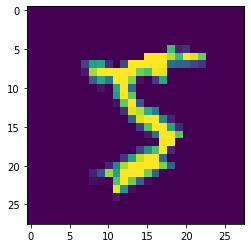

In [26]:
plt.imshow(p1t.value)

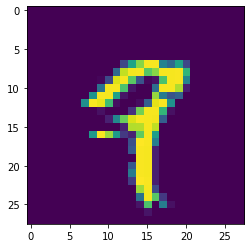

In [27]:
plt.imshow(p0t.value)

In [28]:
def solve_PMK(gamma, p0, p1):
    n = 28
    dx = 1

    mx = cp.Variable((n-1,n))
    my = cp.Variable((n,n-1))
    p0t = cp.Variable((n,n))
    p1t = cp.Variable((n,n))
    col0 = np.zeros((n,1))
    row0 = np.zeros((1,n))

    objective = cp.Minimize(cp.sum(cp.norm(cp.vstack([cp.vec(cp.hstack([my, col0])), cp.vec(cp.vstack([mx, row0]))]),axis=0)))

    # Assumes that p1t has larger mass
    constraints = [
        dx*(p0t - p1t) == cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my]),
        p0t >= 0,
        p0t <= p0,
        p1t >= 0,
        p1t <= p1,
        cp.sum(p0t) == gamma,
        cp.sum(p1t) == gamma,
    ]
    prob = cp.Problem(objective, constraints)
    prob_val = prob.solve()
    return prob_val, p0t.value, p1t.value, mx.value, my.value

In [29]:
gammas = np.linspace(0, np.sum(p0)-0.001, num=20)
p_gammas = []
for gamma in gammas:
    print("Solving problem for", gamma)
    m, _, _, _, _ = solve_PMK(gamma, p0, p1)
    p_gammas.append(m)

Solving problem for 0.0
Solving problem for 0.044335725382754675
Solving problem for 0.08867145076550935
Solving problem for 0.13300717614826402
Solving problem for 0.1773429015310187
Solving problem for 0.22167862691377338
Solving problem for 0.26601435229652803
Solving problem for 0.31035007767928274
Solving problem for 0.3546858030620374
Solving problem for 0.39902152844479205
Solving problem for 0.44335725382754676
Solving problem for 0.4876929792103014
Solving problem for 0.5320287045930561
Solving problem for 0.5763644299758107
Solving problem for 0.6207001553585655
Solving problem for 0.6650358807413201
Solving problem for 0.7093716061240748
Solving problem for 0.7537073315068294
Solving problem for 0.7980430568895841
Solving problem for 0.8423787822723389


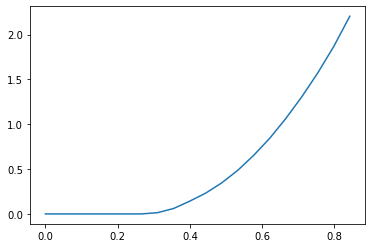

In [30]:
plt.plot(gammas, p_gammas)